Synthetic pressure(t)
 [2794.03368297 2792.70633603 2791.37898909 2790.05164216 2788.72429522
 2787.39694828 2786.06960134 2784.7422544  2783.41490746 2782.08756052
 2780.76021358 2779.43286665 2778.10551971 2776.77817277 2775.45082583
 2774.12347889 2772.79613195 2771.46878501 2770.14143807 2768.81409114
 2767.4867442  2766.15939726 2764.83205032 2763.50470338 2762.17735644
 2760.8500095  2759.52266256 2758.19531562 2756.86796869 2755.54062175
 2754.21327481 2752.88592787 2751.55858093 2750.23123399 2748.90388705
 2747.57654011 2746.24919318 2744.92184624 2743.5944993  2742.26715236
 2740.93980542 2739.61245848 2738.28511154 2736.9577646  2735.63041767
 2734.30307073 2732.97572379 2731.64837685 2730.32102991 2728.99368297] psi
Synthetic noisy pressure data(t)
 [2778.43016188 2792.39656    2785.16970486 2775.4058373  2802.84375643
 2782.62962684 2778.2649092  2795.44493175 2770.5919815  2768.81277151
 2782.02358998 2788.0548038  2785.07288935 2773.43252092 2765.47556519
 2790.11256183 

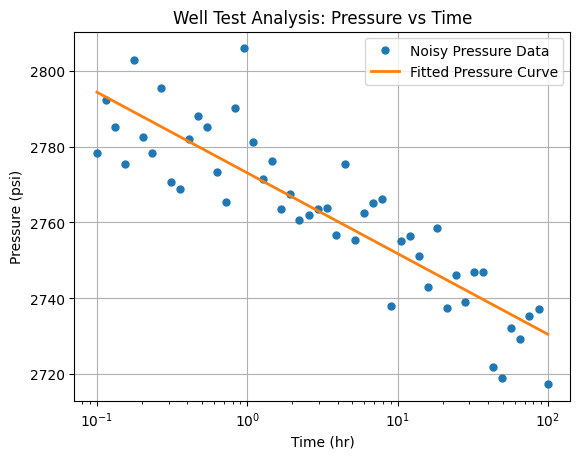

In [16]:
# Objective: Estimate reservoir permeability(k) and skin factor(s) by fitting pressure transient test data.
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

#PARAMETERS
q = 500 #STB/DAY (production rate)
μ = 1 #cP (viscosity)
B = 1.2 #RB/STB (formation volume factor)
h = 30 #ft (reservoir thickness)
ϕ = 0.2 #(porosity)
c_t = 1 * 10**-5 #psi^-1 (total compressibility)
r_w = 0.25 #ft (wellbore radius)
p_i = 3000 #psi (initial pressure)

#time
t = np.logspace(-1,2,50)

#Generating synthetic pressure data assuming true values of k = 150md and s = 5, then add some noise
k = 150 #md(permeability)
s = 5 #skin factor

normal_math = (162.6*q*μ*B)/(k*h)
np_math = np.log10((0.0002637*k*t)/(ϕ*μ*c_t*r_w**2)) + s
pressure = lambda x: p_i - (normal_math * np_math)
pressure_time = pressure(t)
print("Synthetic pressure(t)\n",pressure_time,"psi")

#Adding noise to the synthetic data to mimic real occurencies in the reservoir
np.random.seed(50)
noise = np.random.normal(loc=0, scale=10, size=pressure_time.shape)
noisy_pressure = pressure_time + noise
print("Synthetic noisy pressure data(t)\n", noisy_pressure, "psi")

#Using curve fitting to estimate back the unknown permeability and skin factor from the noisy data (realistic data)

#Firstly defining the unknown permeability and skin factor
def pressure_model(t, k, s):
    term = (162.6 * q * μ * B) / (k * h)
    log_term = np.log10((0.0002637 * k * t) / (ϕ * μ * c_t * r_w**2))
    return p_i - term * (log_term + s)

# Fit the model to the noisy data using curve_fit
initial_guess = [100, 1]  # Initial guess for k and s
popt,cov = curve_fit(pressure_model, t, noisy_pressure, p0=initial_guess)

# Extract estimated values
k_est, s_est = popt
print(f"Estimated permeability (k): {k_est:.2f} md")
print(f"Estimated skin factor (s): {s_est:.2f}")

#Generating the fitted pressure using the estimated K and S
fitted_pressure = pressure_model(t, k_est, s_est)

#VISUALIZATION

#plotting the noisy data as circles
plt.semilogx(t, noisy_pressure, 'o', label='Noisy Pressure Data', markersize=5)

#plotting the fitted curve as a smooth line
plt.semilogx(t, fitted_pressure, '-', label='Fitted Pressure Curve', linewidth=2)

plt.xlabel('Time (hr)')
plt.ylabel('Pressure (psi)')
plt.title('Well Test Analysis: Pressure vs Time')
plt.legend()
plt.grid(True)
plt.show()

#ANIMATION
from matplotlib.animation import FuncAnimation, PillowWriter

# Setup figure
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_xlabel('Time (hr)')
ax.set_ylabel('Pressure (psi)')
ax.set_title('Well Test Analysis')
ax.set_xlim(min(t), max(t))
ax.set_ylim(min(noisy_pressure) - 50, max(noisy_pressure) + 50)
ax.grid(True)

# Initialize plots
noisy_scatter, = ax.plot([], [], 'o', label='Noisy Pressure')
fitted_line, = ax.plot([], [], '-', color='red', label='Fitted Pressure')
ax.legend()

# Create frame data
frames = len(t)

# Update function
def update(i):
    # Progressive noisy points
    noisy_scatter.set_data(t[:i+1], noisy_pressure[:i+1])
    
    # Progressive fitted curve
    t_partial = t[:i+1]
    fitted_partial = pressure_model(t_partial, k_est, s_est)
    fitted_line.set_data(t_partial, fitted_partial)
    
    return noisy_scatter, fitted_line

# Animate
ani = FuncAnimation(fig, update, frames=frames, interval=150, blit=True)

# Save as GIF
ani.save("well_test_dynamic.gif", writer=PillowWriter(fps=10))
plt.close()



  
